In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn
from torch.utils.data import RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from collections import defaultdict
from albumentations import (
    HorizontalFlip,
    VerticalFlip,
    Compose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomGamma
)

from utils.metrics import dice
from utils.data import NeuronSegmDataset

from torch import nn
import torch

from utils.encoders import ResNetEncoders
from unet.unet import UNet

def tonp(t):
    return t.detach().cpu().numpy()
    
def process_batch(b):
    X, y  = b
    X = X.to(DEVICE)
    y = torch.tensor(y, dtype=torch.float).to(DEVICE)
    return X, y

def prediction_to_numpy(pred):
    return pred.sigmoid().detach().cpu().numpy() 

def evaluate(model, loader, threshold):
    model = model.eval()
    for b in loader:
        X, y = process_batch(b)
        res = model(X)
    val_loss = nn.BCEWithLogitsLoss()(res, y)
    pred_Y, real_Y = prediction_to_numpy(res) > threshold, tonp(y)> threshold
    dices = []
    for ypred, yreal in zip(pred_Y, real_Y):
        dices.append(dice(ypred, yreal))
    return np.array(dices).mean(), val_loss.detach().cpu().numpy()




### Create a Fully Connected Segmentation Architecture 
This means it will work similary to any other CONV architecture, in the end it will map the dense layer into a 1,192,192 shape

In [21]:

class SSN(nn.Module):
    def __init__(self):
        super(SSN, self).__init__()

        
        # Create 4 conv layers with 16, 32, 64, 16 inputs
        # Create a Linear layer that will map this into a 192x192 tensor
        # Assume input shape to be (bs, 1, 192, 192)
        

        
    def forward(self, x):
        after_conv = ??? 
        flatten = after_conv.view(after_conv.shape[0], -1)

        lin = self.linear(flatten)
        
    
        return lin.view(x.shape[0],1,192,192)
        

Writing .solutions/ssn.py


### Create a Unet-Like architecture this means a network that will have the pooling path, upsampling and lateral connections.

![alt text](https://cdn-images-1.medium.com/max/1600/1*O2NbipwBOdTMtj7ThBNTPQ.png)

In [2]:

class AlaUnet(nn.Module):
    def __init__(self):
        super(AlaUnet, self).__init__()

        
        self.layer0 = nn.Sequential(nn.Conv2d(1, 4, kernel_size=3, padding=1))
        
        

        self.layer1 = nn.Sequential(
            nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer2 =  # similar to layer1 create layer 2 doubling the amount of filters
        
        self.layer3 =  # similar to layer2 create layer 2 doubling the amount of filters
        
        self.layer4 =  # similar to layer3 create layer 2 doubling the amount of filters
        
        
        self.upsample = # create and Upsample layer (factor=2)
        
        # Upstream layers cant use pooling operations and their sizes need to correpsond with the concatanated output map
        
        self.layer1_up_stream = nn.Sequential(nn.Conv2d(??, ??, kernel_size=1), nn.ReLU())  
        self.layer2_up_stream = nn.Sequential(nn.Conv2d(??, ??, kernel_size=1), nn.ReLU())
        self.layer3_up_stream = nn.Sequential(nn.Conv2d(??, ??, kernel_size=1), nn.ReLU())
        self.layer4_up_stream = nn.Sequential(nn.Conv2d(??, 1, kernel_size=1), nn.ReLU())

        

        
    def forward(self, x):
        down0 = self.layer0(x)
        down1 = self.layer1(down0)
        down2 = self.layer2(down1)
        down3 = self.layer3(down2)
        down4 = self.layer4(down3)
        
        up1 = self.upsample(down4)
        
        
    
        # now you need to concatanate the  up1 with down3
        # ??
        
        # now you need to concatanate the  up2 with down2
        # ??
        
        # now you need to concatanate the  up3 with down1
        # ??
        # now you need to concatanate the  up4 with original X
        x = self.layer4_up_stream(torch.cat([x, up4], dim=1))
        
        
        return x
                


SyntaxError: invalid syntax (<ipython-input-2-4066afd1a9e7>, line 17)

In [17]:
neuron_target = './data/train-labels.tif'
neuron_train = './data/train-volume.tif'


trans_train = transforms.Compose([transforms.Resize(192), 
                                  transforms.ToTensor()])
trans_test = transforms.Compose([transforms.Resize(192), 
                                 transforms.ToTensor()])

aug = Compose([
#     RandomGamma(), 
#                VerticalFlip(), 
#                HorizontalFlip(),
#                RandomRotate90(), 
#                GridDistortion(),
#                ElasticTransform(),
#                OpticalDistortion(distort_limit=1, shift_limit=1)
])


train_ds = NeuronSegmDataset(neuron_train, neuron_target, image_transform=trans_train, augmenter=aug)
test_ds = NeuronSegmDataset(neuron_train, neuron_target, image_transform=trans_test)
train_ds_val = NeuronSegmDataset(neuron_train, neuron_target, image_transform=trans_train)


random_training_sampler = RandomSampler(train_ds)
train_idx , test_idx = train_test_split(range(len(train_ds)), test_size=0.15)

random_sampler_train = RandomSampler(train_idx)
sampler_test = SequentialSampler(test_idx)

training_data_loader = DataLoader(train_ds, batch_size=1, num_workers=1, sampler=random_training_sampler)
test_data_loader = DataLoader(test_ds, batch_size=6, num_workers=1, sampler=sampler_test)
train_ds_val_loader = DataLoader(train_ds_val, batch_size=6, num_workers=1, sampler=random_training_sampler)


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = AlaUnet().to(DEVICE)
model = AlaUnet().to(DEVICE)

optim = torch.optim.Adam(model.parameters())
epochs = 1000
loss_bce = nn.BCEWithLogitsLoss()
loss = 0
THRESHOLD = 0.5
history = defaultdict(list)

/home/i008/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/i008/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


epoch 0
dice 0.9063755690080588
loss 0.35076475
train_dice 0.9188512454354502
train_loss 0.31066957
epoch 1
dice 0.9017662392282808
loss 0.35225442
train_dice 0.9060798167204228
train_loss 0.34993157
epoch 2
dice 0.9072434540471995
loss 0.34857938
train_dice 0.9158231981575778
train_loss 0.33002853
epoch 3
dice 0.9067586302355497
loss 0.34891304
train_dice 0.9096015882901666
train_loss 0.34369177
epoch 4
dice 0.9051028455658446
loss 0.35072777
train_dice 0.9209623784609997
train_loss 0.3091759
epoch 5
dice 0.9066248622988707
loss 0.34826535
train_dice 0.9117219158508263
train_loss 0.34072882
epoch 6
dice 0.9076468309550332
loss 0.3480416
train_dice 0.9153042285970087
train_loss 0.32600304
epoch 7
dice 0.9052109621861202
loss 0.34880042
train_dice 0.909682925328918
train_loss 0.33551392
epoch 8
dice 0.9060506822007609
loss 0.3481946
train_dice 0.9113614693897878
train_loss 0.3374044
epoch 9
dice 0.9072323951584842
loss 0.34922317
train_dice 0.9095015920622553
train_loss 0.35198718
epoch

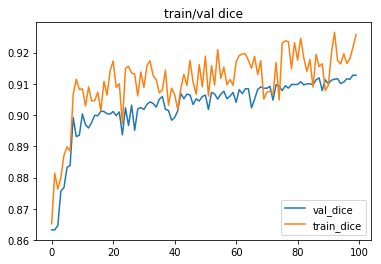

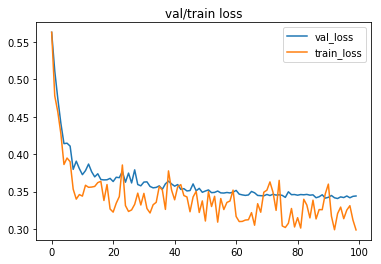

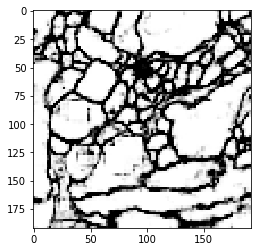

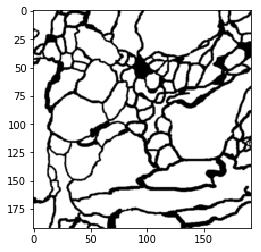

In [19]:
epochs=50

for i, _ in enumerate(range(epochs)):
    for batch in training_data_loader:
        X, y = process_batch(batch)
        prediction = model(X)  # [N, 2, H, W]
        loss = loss_bce(prediction, y)   
        optim.zero_grad()
        loss.backward()
        optim.step()   
        
    val_mean_dice, val_loss = evaluate(model, test_data_loader, threshold=THRESHOLD)
    train_mean_dice, train_loss = evaluate(model, train_ds_val_loader, threshold=THRESHOLD)
    
    print("epoch", i)
    print('dice', val_mean_dice)
    print('loss', val_loss)
    print('train_dice', train_mean_dice)
    print('train_loss', train_loss)
    model.train()
    
    history['val_dice'].append(val_mean_dice)
    history['val_loss'].append(val_loss)
    history['train_dice'].append(train_mean_dice)
    history['train_loss'].append(train_loss)
    
    

df = pd.DataFrame(history)

plt.figure()
plt.title('train/val dice')
plt.plot(df.val_dice)
plt.plot(df.train_dice)
plt.legend(['val_dice', 'train_dice'])
plt.figure()
plt.title('val/train loss')
plt.plot(df.val_loss)
plt.plot(df.train_loss)
plt.legend(['val_loss', 'train_loss'])


plt.figure()
plt.imshow(prediction[0][0].detach().sigmoid().cpu().numpy(), cmap='gray')
plt.figure()
plt.imshow(y.detach()[0][0].cpu().numpy(), cmap='gray')
